In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import matplotlib.pyplot as plt

def getData():
    df = pd.read_csv("1/SOLUSDC.csv")
    df["Open time"] = df["Open time"].apply(lambda x: x * 1000 if len(str(x)) < len("1738369800000000") else x)
    df["Open time"] = pd.to_datetime(df["Open time"], unit='us')
    df.set_index("Open time", inplace=True)
    df.sort_index(inplace=True)

    df["Gap"] = df.index.to_series().diff().dt.total_seconds().div(60).fillna(0)
    valid_intervals = df[df["Gap"] <= 30]
    last_gap_index = df[df["Gap"] > 30].index[-1]
    df = df.loc[last_gap_index:]
    df.drop(columns=["Gap", "Ignore", "Close time"], inplace=True)

    # define stupid sawtooth to test
    cycle = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    for i in range(0, len(df)):
        df.iloc[i, 0] = cycle[i % len(cycle)] + 1
    return df.iloc[9000:,:1]

getData().head()

,Open
Open time,
2025-02-04 12:00:00,1.0
2025-02-04 12:30:00,1.1
2025-02-04 13:00:00,1.2
2025-02-04 13:30:00,1.3
2025-02-04 14:00:00,1.4


In [2]:
getData().to_csv("1/sawtooth.csv")

In [3]:
# BLANK FOR NOW
# (optional) put stuff in
def add_financial_indicators(df):
    df["Returns"] = df["Open"].pct_change().shift(-1)
    return df

In [4]:
""" THESE ARE GLOBAL VARIABLES """
SQNC_LOOKBACK = 10
SQNC_RUNFORWARD = 3
ACTION_SIZE = 0 # set by sqnc_rtns_getters
STATE_DATA_SIZE = 0 # set by sqnc_rtns_getters
STATE_INTERNAL_SIZE = 0
""" OKAY??? GLOBAL!!! """


def sqnc_rtns_getters():
    global ACTION_SIZE, STATE_DATA_SIZE

    df = getData()
    ACTION_SIZE = 1

    df = add_financial_indicators(df)

    normalized_df = df.copy()
    normalized_df.drop(columns=["Returns"], inplace=True)
    scaler = preprocessing.MinMaxScaler()
    normalized_columns = scaler.fit_transform(normalized_df)
    normalized_df = pd.DataFrame(normalized_columns, columns=normalized_df.columns, index=normalized_df.index)
    STATE_DATA_SIZE = len(normalized_df.columns)
    
    

    state_df = normalized_df.copy()
    def getSequence(testing=False, training=False, seed=None):
        state_arrays = state_df.values
        indices = np.arange(len(state_arrays))

        testing_index = int(len(df) * 0.8)
        if testing:
            indices = indices[testing_index:-1]
        elif training:
            if seed:
                rng = np.random.default_rng(seed)
                randomStart = rng.integers(SQNC_LOOKBACK, testing_index - SQNC_RUNFORWARD)
            else:
                randomStart = np.random.randint(SQNC_LOOKBACK, testing_index - SQNC_RUNFORWARD)
            indices = indices[randomStart:randomStart + SQNC_RUNFORWARD]
        
        blankDf = pd.DataFrame(np.zeros((len(indices), ACTION_SIZE)), index=indices)
        blankDf[:] = np.nan
        def state_generator():
            for i in indices:
                yield state_arrays[i - SQNC_LOOKBACK:i]
            yield None # a courtesy most generators do not supply
            
        return { 'actions_notebook': blankDf, 'state_gen': state_generator() }

    
    def getReturns(actions):
        # actions is a time_indices-indexed df of portfolio weights, just one column for now
        actions = actions.iloc[:, 0]
        returns = []
        for i in actions.index:
            if np.isnan(actions[i]):
                break
            period_return = df.iloc[i]["Returns"] * actions[i]
            returns.append(period_return)
        return returns
    
    return getSequence, getReturns
    

getSequence, getReturns = sqnc_rtns_getters()

In [5]:
recentActions = None

def setFirstNA(df, value):
    first_na_index = df[df.isna().any(axis=1)].index[0]
    df.loc[first_na_index] = value
    return df

class PortfolioEnv(Env):
    def __init__(self, seed=None, testing=False):
        super(PortfolioEnv, self).__init__()

        global ACTION_SIZE, STATE_DATA_SIZE, STATE_INTERNAL_SIZE

        self.action_space = Box(low=0, high=1, shape=(ACTION_SIZE,), dtype=np.float64)
        self.observation_space = Box(low=0, high=1, shape=(SQNC_LOOKBACK, STATE_DATA_SIZE + STATE_INTERNAL_SIZE,), dtype=np.float64)
        
        self.testing = testing
        self.training = 1 - self.testing
        d = getSequence(training=self.training, testing=self.testing, seed=seed)
        self.sequenceGen = d['state_gen']
        self.actionsNotebook = d['actions_notebook']
        self.state = self.sequenceGen.__next__()

    def step(self, action):
        setFirstNA(self.actionsNotebook, action)
        
        returns = getReturns(self.actionsNotebook)
        reward = returns[-1]

        self.state = self.sequenceGen.__next__()
        terminated = False
        truncated = False if self.state is not None else True
        return self.state, reward, terminated, truncated, {}

    def reset(self, seed=None, testing=False):
        super().reset(seed=seed)
        
        d = getSequence(training=self.training, testing=self.testing, seed=seed)
        self.sequenceGen = d['state_gen']
        self.actionsNotebook = d['actions_notebook']
        self.state = self.sequenceGen.__next__()
        return self.state, {}
    
env = DummyVecEnv([lambda: PortfolioEnv()])

In [6]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000)

test_env = DummyVecEnv([lambda: PortfolioEnv(testing=True)])
obs = test_env.reset()
cumulativeReturns = []
actions = []
done = False
i = 0
while not done:
    i += 1
    if i % 100 == 0:
        print(f"Step {i}")
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)
    cumulativeReturns.append(reward)
    actions.append(action[0])

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 374  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 334         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011408338 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -1.31       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00665     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0156     |
|    std                  | 0.997       |
|    value_loss           | 0.00785     |
-----------------

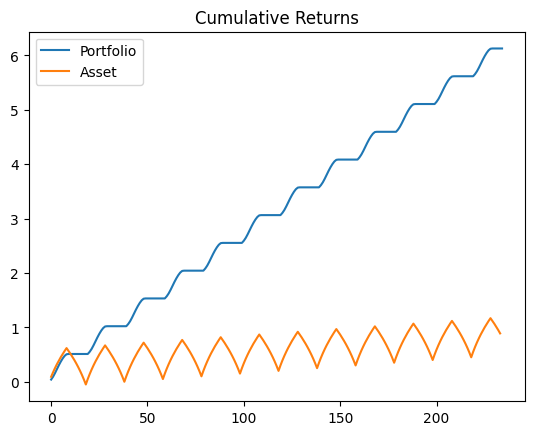

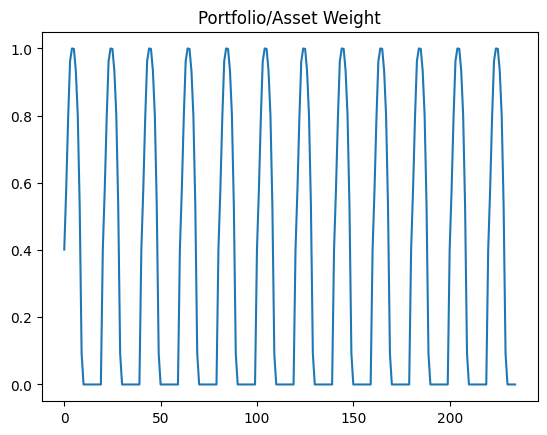

In [12]:
plt.plot(np.cumsum(cumulativeReturns), label="Portfolio")

returns = np.array(add_financial_indicators(getData())["Returns"].iloc[-len(cumulativeReturns):,])
plt.plot(np.cumsum(returns), label="Asset")
plt.title("Cumulative Returns")
plt.legend()
plt.show()

plt.plot(actions)
plt.title("Portfolio/Asset Weight")
plt.show()